In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

In [ ]:
warnings.filterwarnings("ignore")

# Load Month Rain Dataset
data = pd.read_csv('/content/Month_Rain.csv')
print("Dataset Loaded:")
print(data.head())

Dataset Loaded:
   YEAR   JAN   FEB   MAR   APR   MAY    JUN    JUL    AUG    SEP    OCT  \
0  1901  34.7  38.6  17.8  38.9  50.6  113.2  241.4  271.6  124.7   52.4   
1  1902   7.4   4.2  19.0  44.1  48.8  111.7  284.9  201.0  200.2   62.5   
2  1903  16.7   8.0  31.1  17.1  59.5  120.3  293.2  274.0  198.1  119.5   
3  1904  14.9   9.7  31.4  33.7  73.8  165.5  260.3  207.7  130.8   69.8   
4  1905  24.7  20.3  41.8  33.8  55.8   93.7  253.0  201.7  178.1   54.9   

    NOV   DEC  Annual  
0  38.7   8.2  1030.8  
1  29.4  25.2  1038.4  
2  40.3  18.0  1195.8  
3  11.2  16.4  1025.2  
4   9.6  10.1   977.5  


In [ ]:
print(data.head())

   YEAR   JAN   FEB   MAR   APR   MAY    JUN    JUL    AUG    SEP    OCT  \
0  1901  34.7  38.6  17.8  38.9  50.6  113.2  241.4  271.6  124.7   52.4   
1  1902   7.4   4.2  19.0  44.1  48.8  111.7  284.9  201.0  200.2   62.5   
2  1903  16.7   8.0  31.1  17.1  59.5  120.3  293.2  274.0  198.1  119.5   
3  1904  14.9   9.7  31.4  33.7  73.8  165.5  260.3  207.7  130.8   69.8   
4  1905  24.7  20.3  41.8  33.8  55.8   93.7  253.0  201.7  178.1   54.9   

    NOV   DEC  Annual  
0  38.7   8.2  1030.8  
1  29.4  25.2  1038.4  
2  40.3  18.0  1195.8  
3  11.2  16.4  1025.2  
4   9.6  10.1   977.5  


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YEAR    112 non-null    int64  
 1   JAN     112 non-null    float64
 2   FEB     112 non-null    float64
 3   MAR     112 non-null    float64
 4   APR     112 non-null    float64
 5   MAY     112 non-null    float64
 6   JUN     112 non-null    float64
 7   JUL     112 non-null    float64
 8   AUG     112 non-null    float64
 9   SEP     112 non-null    float64
 10  OCT     112 non-null    float64
 11  NOV     112 non-null    float64
 12  DEC     112 non-null    float64
 13  Annual  112 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 12.4 KB
None


In [ ]:
print("Missing values detected. Replacing with mean...")
# Check for Missing Values & Replace with Mean
numeric_cols = data.select_dtypes(include=np.number).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

Missing values detected. Replacing with mean...


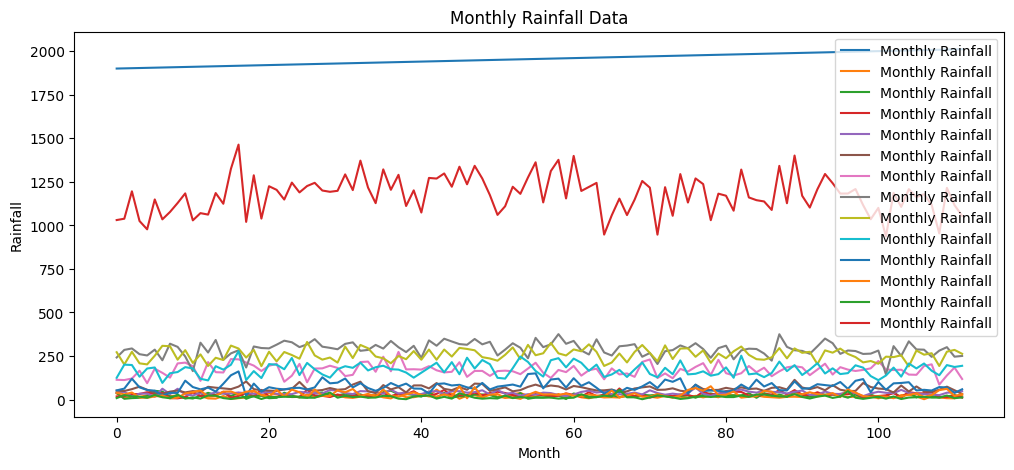

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 5))
plt.plot(data, label='Monthly Rainfall')
plt.legend()
plt.title('Monthly Rainfall Data')
plt.xlabel('Month')
plt.ylabel('Rainfall')

plt.show()

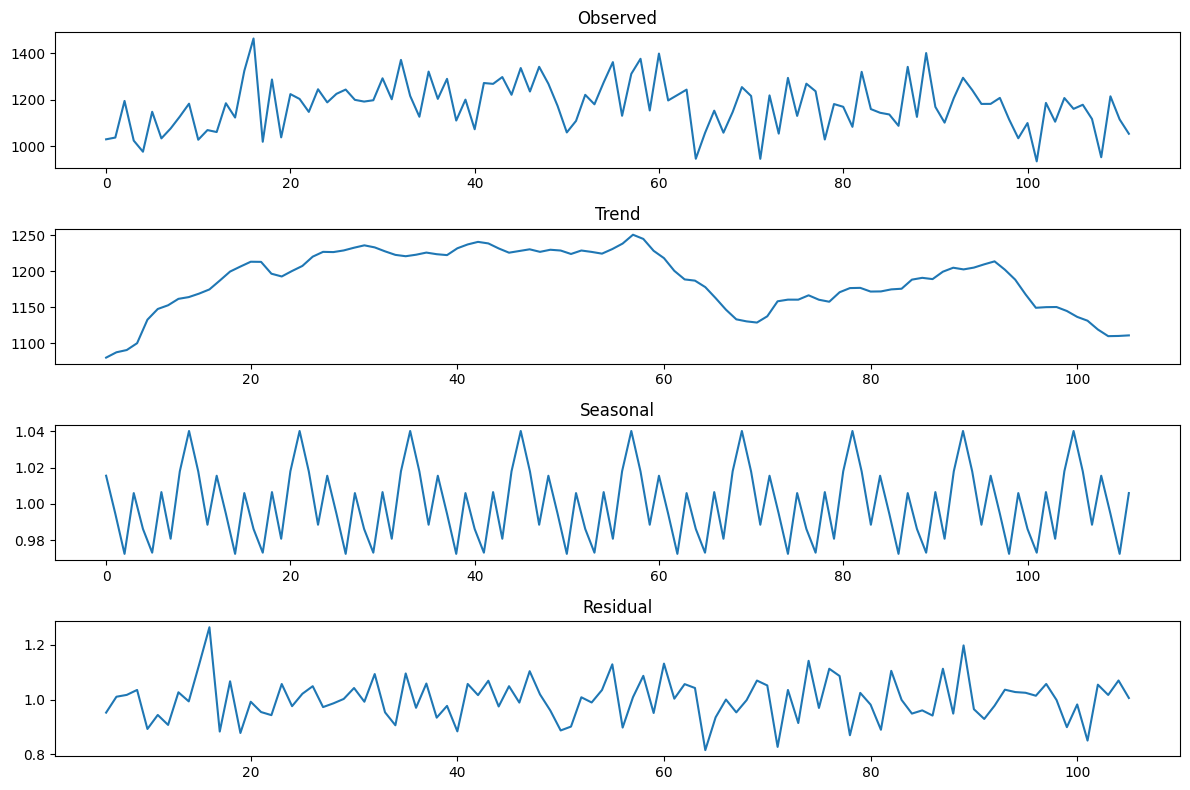

In [ ]:
# Time Series Decomposition
decomposition = seasonal_decompose(data['Annual'], model='multiplicative', period=12)
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

In [ ]:
# Checking Stationarity & Transforming Data
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    return result[1] <= 0.05

In [ ]:
# Log Transformation to Stabilize Variance
data_log = np.log(data['Annual']) # Apply log transformation to the 'Annual' column only
if not check_stationarity(data_log):
    print("Data is not stationary after log transformation, applying first-order differencing...")
    data_diff = data_log.diff().dropna()
    if not check_stationarity(data_diff):
        print("Data is still not stationary, applying second-order differencing...")
        data_diff = data_diff.diff().dropna()
else:
    data_diff = data_log

ADF Statistic: -4.159912818128324
p-value: 0.0007697677092167379
Critical Values:
   1%: -3.4924012594942333
   5%: -2.8886968193364835
   10%: -2.5812552709190673


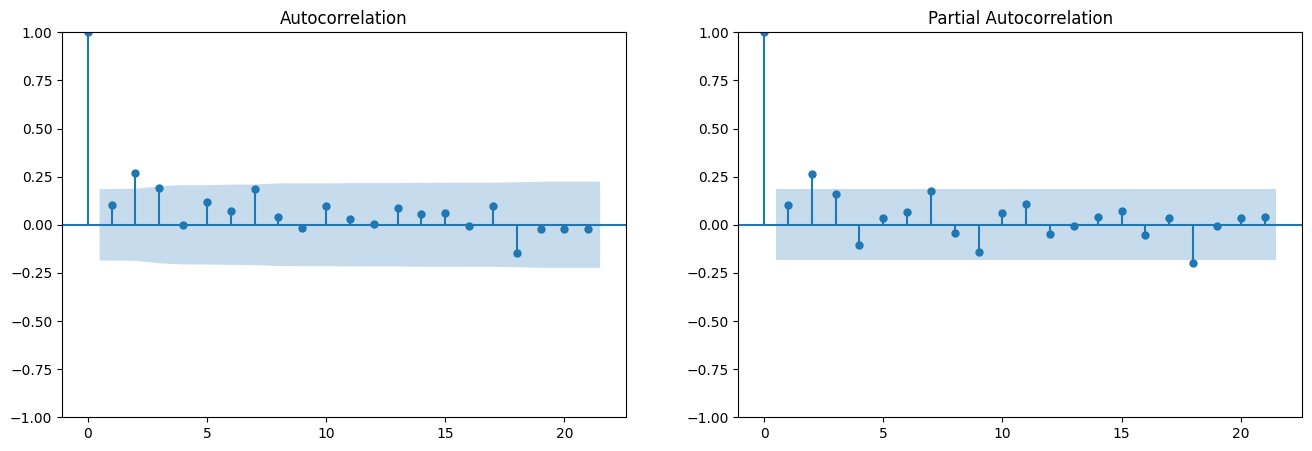

In [ ]:
# Autocorrelation & Partial Autocorrelation Plots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(data_diff, ax=axes[0])
plot_pacf(data_diff, ax=axes[1])
plt.show()

In [ ]:
# Splitting Data
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [ ]:
# SARIMA Model Training
# Splitting Data
train_size = int(len(data) * 0.8)
# Select the 'Annual' column as the target variable for the SARIMA model
train, test = data['Annual'].iloc[:train_size], data['Annual'].iloc[train_size:]
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Annual   No. Observations:                   89
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -476.828
Date:                            Tue, 01 Apr 2025   AIC                            963.657
Time:                                    08:15:57   BIC                            975.311
Sample:                                         0   HQIC                           968.314
                                             - 89                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1556      0.132     -1.181      0.238      -0.414       0.103
ma.L1         -0.8152      0.101   

In [ ]:
# Model Evaluation
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')

MAE: 82.94650643688901, MSE: 13344.249881177078, RMSE: 115.5173142051748


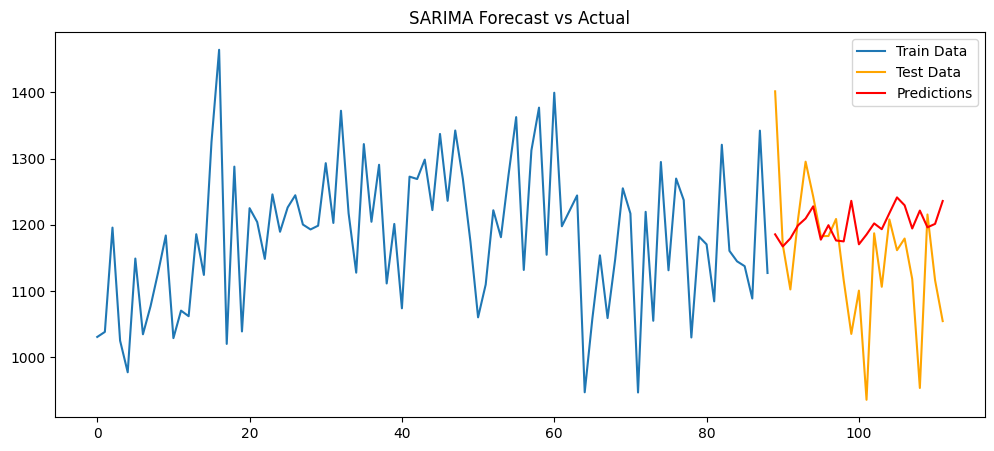

In [ ]:
# Plotting Predictions
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train Data')
plt.plot(test, label='Test Data', color='orange')
plt.plot(predictions, label='Predictions', color='red')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.show()

In [ ]:
# Forecasting Future Values
future_steps = 12
forecast = model_fit.forecast(steps=future_steps)
print(f'Forecasted Values:\n{forecast}')

Forecasted Values:
89     1185.612163
90     1167.367518
91     1179.478586
92     1199.095151
93     1209.502872
94     1227.904393
95     1177.631755
96     1199.422381
97     1176.362798
98     1174.957746
99     1236.209131
100    1170.583654
Name: predicted_mean, dtype: float64


In [ ]:
# User Input & Prediction
steps = int(input("Enter the number of future steps to predict: "))
user_forecast = model_fit.forecast(steps=steps)
print(f'Predicted values for next {steps} steps:\n{user_forecast}')

Enter the number of future steps to predict: 3
Predicted values for next 3 steps:
89    1185.612163
90    1167.367518
91    1179.478586
Name: predicted_mean, dtype: float64


In [ ]:
# User Input & Prediction
steps = int(input("Enter the number of future steps to predict: "))
user_forecast = model_fit.forecast(steps=steps)
print(f'Predicted values for next {steps} steps:\n{user_forecast}')

Enter the number of future steps to predict: 4
Predicted values for next 4 steps:
89    1185.612163
90    1167.367518
91    1179.478586
92    1199.095151
Name: predicted_mean, dtype: float64
